In [1]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt




In [6]:
# Load SP500 and US macroeconomic data from CSV files
data = pd.read_csv('./data/SP500_data/GOOGL.csv', parse_dates=['Date'])
macro_data = pd.read_csv('./data/SP500_data/US_macroeconomics.csv', parse_dates=['date'])

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)  # Set the date column as the index if not already set

# Merge datasets on the date field
merged_data = pd.merge(data, macro_data, left_on='Date', right_on='date', how='outer')

# Handle missing values: forward fill then backward fill to cover all gaps
merged_data.interpolate(method='ffill', inplace=True)
merged_data.interpolate(method='bfill', inplace=True)

# Drop the extra date column to avoid duplication
merged_data.drop(columns=['date'], inplace=True)

print(merged_data)


             Open         High          Low        Close    Adj Close  \
0       50.050049    52.082081    48.028027    50.220219    50.220219   
1       50.555557    54.594597    50.300301    54.209209    54.209209   
2       55.430431    56.796799    54.579578    54.754753    54.754753   
3       55.675674    55.855858    51.836838    52.487488    52.487488   
4       52.532532    54.054054    51.991993    53.053055    53.053055   
...           ...          ...          ...          ...          ...   
4787  2784.000000  2832.379883  2755.010010  2831.439941  2831.439941   
4788  2784.000000  2832.379883  2755.010010  2831.439941  2831.439941   
4789  2784.000000  2832.379883  2755.010010  2831.439941  2831.439941   
4790  2784.000000  2832.379883  2755.010010  2831.439941  2831.439941   
4791  2784.000000  2832.379883  2755.010010  2831.439941  2831.439941   

          Volume      CPI  Mortgage_rate  Unemp_rate        NASDAQ  \
0     44659096.0  189.800         5.7540         5.4 

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607:

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97827D+00    |proj g|=  2.70449D-02

At iterate    5    f=  2.97743D+00    |proj g|=  7.84915D-03

At iterate   10    f=  2.97723D+00    |proj g|=  3.09727D-03

At iterate   15    f=  2.97157D+00    |proj g|=  9.05879D-02

At iterate   20    f=  2.96870D+00    |proj g|=  2.55800D-03

At iterate   25    f=  2.96868D+00    |proj g|=  1.80793D-04

At iterate   30    f=  2.96868D+00    |proj g|=  3.63340D-04

At iterate   35    f=  2.96868D+00    |proj g|=  1.19497D-03

At iterate   40    f=  2.96845D+00    |proj g|=  1.02550D-02

At iterate   45    f=  2.96808D+00    |proj g|=  1.95078D-03

At iterate   50    f=  2.96789D+00    |proj g|=  1.32803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

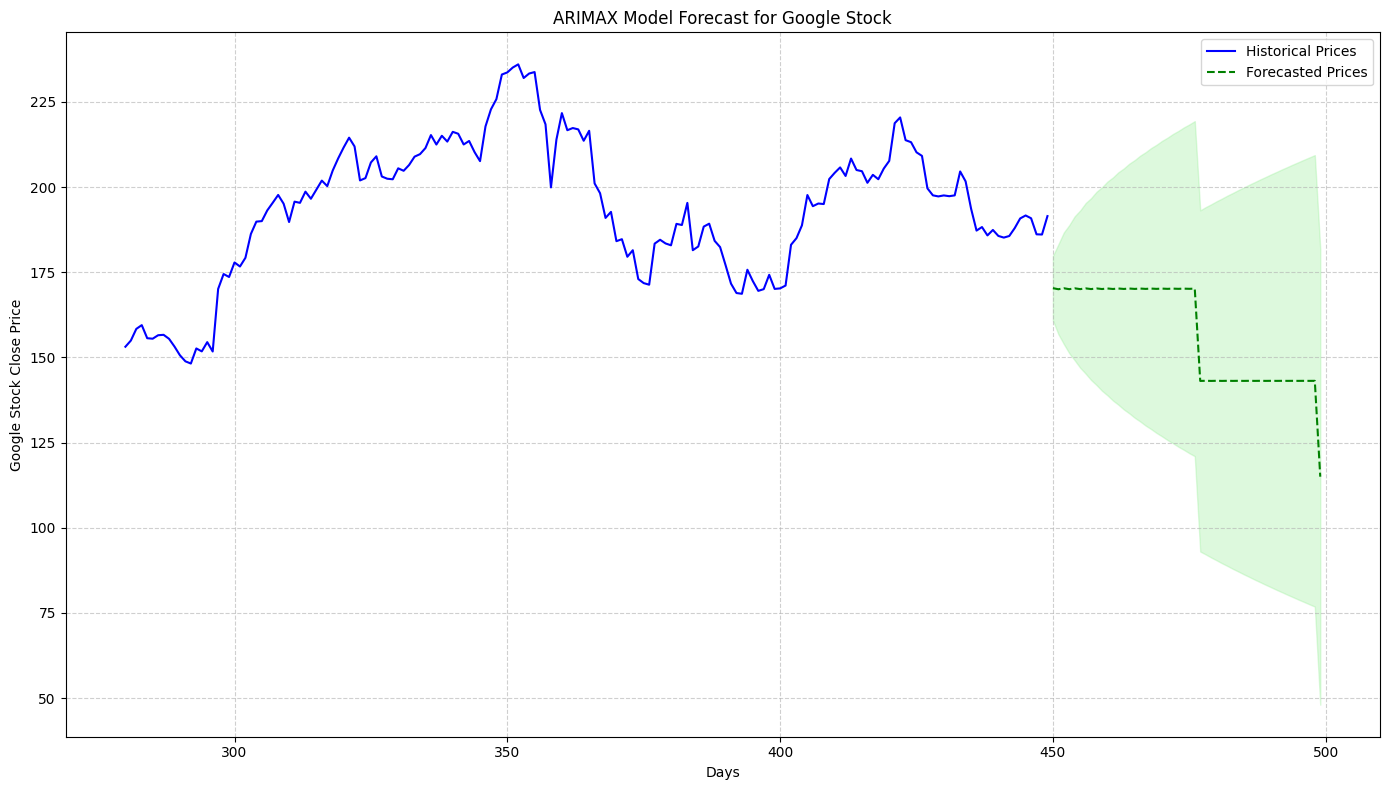

In [21]:
# Define row ranges
startRow = 280
stopRow = 400
steps = 50

def build_arimax_model(data, exog, order=(2, 1, 2)):
    model = SARIMAX(data, exog=exog, order=order)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate_stock(model, steps, exog=None):
    forecast_result = model.get_forecast(steps=steps, exog=exog)
    forecast_mean = forecast_result.predicted_mean

    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals



# Train and test split
train = merged_data[startRow:stopRow]
test = merged_data[stopRow:stopRow + steps]

# Specify endogenous and exogenous variables
y_train = train['Close']
y_test = test['Close']
X_train = train[['CPI', 'Mortgage_rate', 'Unemp_rate', 'NASDAQ', 'disposable_income', 'Personal_consumption_expenditure', 'personal_savings']]
X_test = test[['CPI', 'Mortgage_rate', 'Unemp_rate', 'NASDAQ', 'disposable_income', 'Personal_consumption_expenditure', 'personal_savings']]

# Build ARIMAX model
model = build_arimax_model(y_train, exog=X_train)

# Simulate future prices
forecast_series, conf_df = forecast_and_simulate_stock(model, steps, exog=X_test)

# Visualization
plt.figure(figsize=(14, 8))

historical_data = pd.concat([y_train, y_test])

# Plot historical prices
plt.plot(historical_data.index, historical_data.values, label="Historical Prices", color='blue')

# Create consecutive integers for forecast indices
forecast_index = historical_data.index[-1] + np.arange(1, len(forecast_series) + 1)

# Plot forecasted prices
plt.plot(forecast_index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between confidence intervals
plt.fill_between(forecast_index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Days")
plt.ylabel("Google Stock Close Price")
plt.legend()

# Add title and show the plot
plt.title("ARIMAX Model Forecast for Google Stock")
plt.tight_layout()
plt.show()